In [312]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

datafiles = ["gor.h5", "Kolmogorov.h5", "aida.h5", "odinmaniac-ThinkPad-T14s-Gen-1.h5"]

experiments = pd.concat([pd.read_hdf(datafile) for datafile in datafiles], axis=0)
# experiments["seed"].fillna(-100, inplace=True)
experiments.dropna(inplace=True)
experiments = experiments[experiments.valid_columns & experiments.valid_time_final]


In [313]:
nominals = experiments[experiments.controller == "calf_ex_post"]
nominals = nominals[nominals.finished_episodes == 1]

safe_onlys = []
for o in nominals.overrides:
    parsed = json.loads(o)
    if parsed.get("+controller.safe_only") is not None:
        safe_onlys.append(parsed.get("+controller.safe_only") == "True")
    else:
        safe_onlys.append(False)

nominals = nominals.loc[safe_onlys]

nominals = nominals.groupby(["controller", "system", "seed"])[
    "best_total_objective"
].max()
nominals = nominals[nominals < 10e4]
nominals = nominals.loc["calf_ex_post"]
nominals = nominals.droplevel("seed", axis=0)

In [314]:
[
    "mpc",
    "rql",
    "rpo",
    "calf_ex_post",
    "calf_predictive",
    "dqn",
    "ddqn",
    "ddpg",
    "acpg",
    "sarsa",
    "nominal",
]



['mpc',
 'rql',
 'rpo',
 'calf_ex_post',
 'calf_predictive',
 'dqn',
 'ddqn',
 'ddpg',
 'acpg',
 'sarsa',
 'nominal']

In [315]:
basic = [
    "rql",
    "dqn",
    "ddqn",
    "ddpg",
    "acpg",
    "sarsa",
    "rpo",
    "calf_ex_post",
    "calf_predictive",
]
finished_episodes_thr = 20


def process_controllers(controllers, experiments, finished_episodes_thr=20):
    aggregated = {}
    for controller in controllers:
        controller_experiments = experiments[
            (experiments.controller == controller)
            & (experiments.finished_episodes == finished_episodes_thr)
        ]

        ids = (
            controller_experiments.groupby(["system", "seed"])["best_total_objective"]
            .idxmax()
            .values
        )
        controller_experiments = controller_experiments.loc[ids].set_index("system")
        controller_systems = list(controller_experiments.index.unique())

        item = {}
        for s in controller_systems:
            if isinstance(controller_experiments.loc[s].total_objectives, pd.DataFrame):
                item[s] = controller_experiments.loc[s].total_objectives.set_index(
                    "episode"
                )
            else:
                item[s] = pd.concat(
                    [
                        v.set_index("episode")
                        for v in controller_experiments.loc[s].total_objectives.tolist()
                    ],
                    axis=1,
                )
        aggregated[controller] = item

    return aggregated


aggregated = process_controllers(
    [
        "rql",
        "dqn",
        "ddqn",
        "ddpg",
        "acpg",
        "sarsa",
        "rpo",
        "calf_ex_post",
        "calf_predictive",
    ],
    experiments,
    20,
)

aggregated["calf"] = aggregated["calf_ex_post"] | aggregated["calf_predictive"]
aggregated["nominal"] = nominals

In [316]:
mpc_experiments = experiments[experiments.controller == "mpc"]
mpc_experiments["horizon"] = [
    json.loads(o).get("controller.actor.predictor.prediction_horizon")
    for o in mpc_experiments.overrides
]
mpc_experiments.dropna(inplace=True)
mpc_experiments.controller = (
    mpc_experiments.controller + "N" + mpc_experiments["horizon"]
)

aggregated.update(
    process_controllers(
        mpc_experiments.controller.unique().tolist(), mpc_experiments, 1
    )
)

/tmp/ipykernel_1404774/2977136432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpc_experiments["horizon"] = [
/tmp/ipykernel_1404774/2977136432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpc_experiments.dropna(inplace=True)
/tmp/ipykernel_1404774/2977136432.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

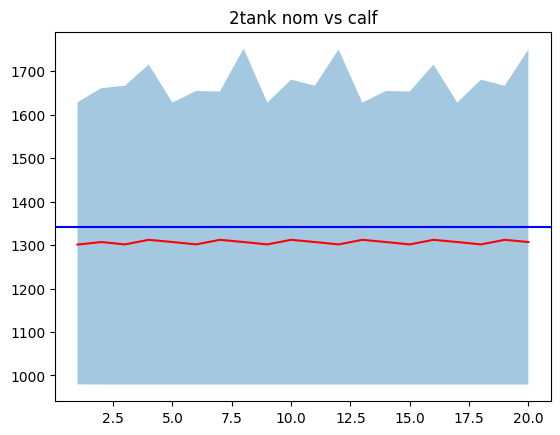

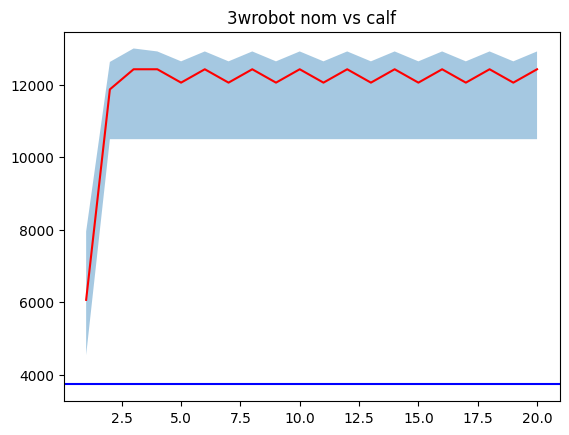

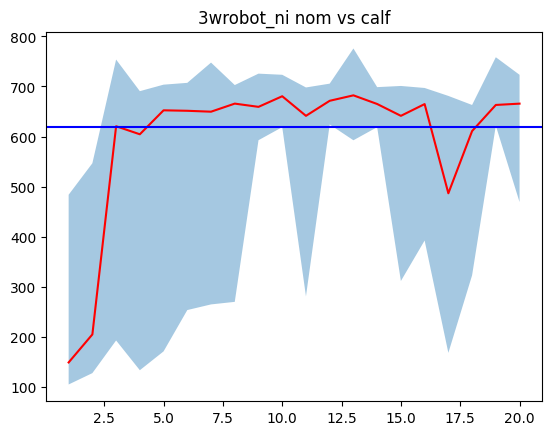

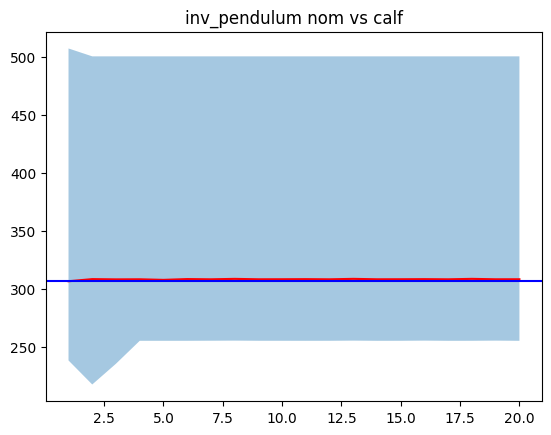

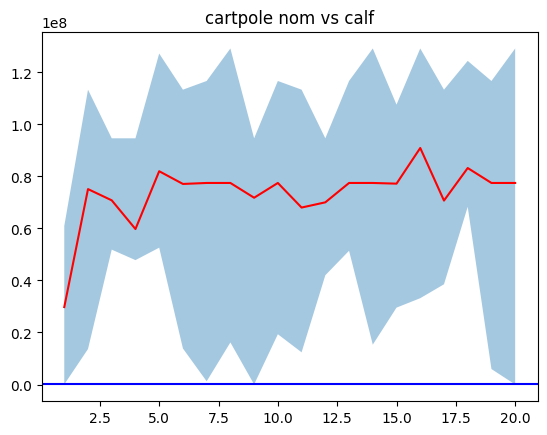

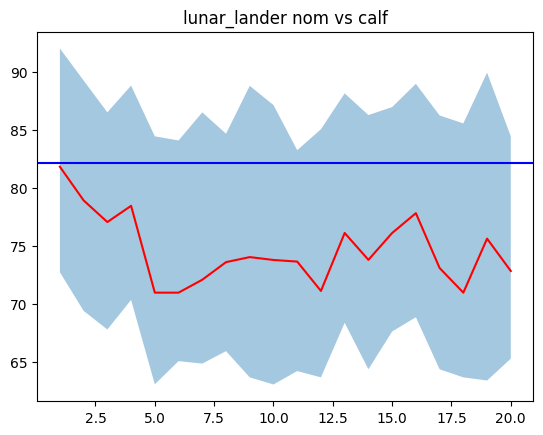

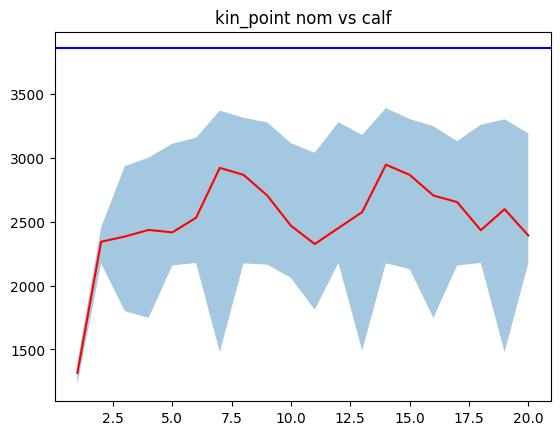

In [324]:
aggregated.keys()
systems = [
    "2tank",
    "3wrobot",
    "3wrobot_ni",
    "inv_pendulum",
    "cartpole",
    "lunar_lander",
    "kin_point",
]


for s in systems:
    plt.title(s + " nom vs calf")
    plt.plot()
    
    lower_bounds = aggregated["calf"][s].quantile(q=0.75, axis=1)
    values = aggregated["calf"][s].quantile(q=0.5, axis=1)
    upper_bounds = aggregated["calf"][s].quantile(q=0.25, axis=1)
    plt.plot(values, c='r')
    plt.fill_between(values.index, lower_bounds.values, upper_bounds.values, alpha=.4)
    plt.axhline(aggregated["nominal"].loc[s].median(), c='b')
    plt.show()
    

In [ ]:
systems = [
    "2tank",
    "3wrobot_ni",
    "3wrobot",
    "cartpole",
    "inv_pendulum",
    "kin_point",
    "lunar_lander",
]

controller = "rql"
system = "lunar_lander"
for system in systems:
    plt.plot(
        pd.concat(
            [
                experiments.loc[controller, system, seed]
                .total_objectives[0]
                .set_index("episode")
                for seed in experiments.loc[controller, system].index
            ],
            axis=1,
        ).mean(axis=1)
    )
    plt.title(f"{controller} {system} mean")
    # plt.yscale("log")
    plt.grid()
    plt.show()

In [ ]:
systems = [
    "2tank",
    "3wrobot_ni",
    "3wrobot",
    "cartpole",
    "inv_pendulum",
    "kin_point",
    "lunar_lander",
]
controllers = ["dqn", "ddqn", "rql", "acpg", "ddpg"]


for system in systems:
    for controller in controllers:
        df = pd.concat(
            [
                experiments.loc[controller, system, seed]
                .total_objectives[0]
                .set_index("episode")
                for seed in experiments.loc[controller, system].index
            ],
            axis=1,
        )
        mean_controller_episodic_perfomance = df.mean(axis=1)

        axes = plt.plot(mean_controller_episodic_perfomance)

        ci = 95

        low = np.percentile(df.values, 50 - ci / 2, axis=1)
        high = np.percentile(df.values, 50 + ci / 2, axis=1)

        plt.fill_between(df.index, low, high, color="r", alpha=0.2)

        axes.plot(df.index, df.values, color="r", alpha=0.2)
        df["mean_traj"] = df.mean(axis=1)
        axes.plot(
            df.index,
            df.mean_traj.values,
            color="b",
            label=f"mean {environment} Total objective",
        )
    plt.title(f"{controller} {system} mean")
    # plt.yscale("log")
    plt.grid()
    plt.show()